# Overview: The target variable is distinguishing which class the car condition belongs to. 
It is a multi-class classification problem

## The following is the workflow for devising a model that predicts these well based on the performance metric chosen

1. Data Cleaning, Exploration and Visualization
2. Split the data into train- test
3. Feature Scaling and data treatment
4. Select a performance measure 
5. Finalize the model algorithm using nested CV
6. Fine tune the hyper parameters of the selected algorithm to finalize the model

The data set has been downloaded from - http://archive.ics.uci.edu/ml/datasets/Car+Evaluation

In this notebook,I am going to use the following predictive techniques:
  -Naive bayes
  -Multiclass logistic regression
  -KNN
  -Decision tree 
  -SVM 
After choosing the best hyperparamaters for each model, we will compare their performance based on the f_1 score 

In [4]:
# read the data and naming the columns
path = "D:/MSBA/Fall term/MSBA 6420 - Predictive Analytics/HW2/"
df = pd.read_csv(path + "car.data", header = None)
df.rename(columns = {0: 'buying', 1: 'maint', 2: 'doors', 3: 'persons', 4: 'lug_boot', 5:'safety', 6: 'class'}, inplace = True)

FileNotFoundError: File b'D:/MSBA/Fall term/MSBA 6420 - Predictive Analytics/HW2/car.data' does not exist

In [2]:
import pandas as pd
import numpy as np 
import sklearn
from  sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegressionCV
import warnings; warnings.simplefilter('ignore')
## Plotting Learning Curves

# A learning curve shows the validation and training score of an estimator for varying numbers of training samples. 
# It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. 
# If both the validation score and the training score converge to a value that is too low with increasing size of the training set, 
# we will not benefit much from more training data. 

# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,scoring_metric = None, scoring_metric_label = "score",
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring_metric_label)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring_metric)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_results( grid ,par_1,par_2, title, y_lab):
    """Select two hyperparameters from which we plot the fluctuations"""
    index = 'param_' + par_1
    columns = 'param_' + par_2

    # prepare the results into a pandas.DataFrame
    df = pd.DataFrame(grid.cv_results_)

    # Remove the other by selecting their best values (from gscv.best_params_)
    other = [c for c in df.columns if c[:6] == 'param_']
    other.remove(index)
    other.remove(columns)
    # Create pivot tables for easy plotting
    table_mean = df.pivot_table(index=index, columns=columns,
                                values=['mean_test_score'])
    table_std = df.pivot_table(index=index, columns=columns,
                               values=['std_test_score'])

    # plot the pivot tables
    plt.figure()
    ax = plt.gca()
    for col_mean, col_std in zip(table_mean.columns, table_std.columns):
        table_mean[col_mean].plot(ax=ax, yerr=table_std[col_std], marker='o',
                                  label=col_mean)
    plt.title(title)
    plt.ylabel(y_lab)
    plt.legend(title=table_mean.columns.names)
    plt.show()


#plot_results(index='dar__ordar', columns='dar__ordriv')
#plot_results(index='driver__low_fq', columns='driver__low_fq_width')



Let's start with the naive bayes model

In [32]:
# Given that the features are categorical, and in order to use gaussian naive bayes, 
# we will convert the features to numerical data instead of onehotencoding, as onehotenconding
# will significantly break the independency rule
df_naivebayes = df.replace({'buying': {'low' : 1, 'med' : 2, 'high' : 3, 'vhigh' : 4},
            'maint' : {'low' : 1, 'med' : 2, 'high' : 3, 'vhigh' : 4},
           'doors' : {'2': 2, '3' : 3, '5more' : 5},
           'persons':{ '2':2,'4':4,'more':6},
           'lug_boot' : {'small':1, 'med':2, 'big':3},
           'safety' : {'low':1, 'med':2, 'high':3}})

In [33]:
# let's split the data using stratified sampling
df_y = df_naivebayes.iloc[:,6].values
df_x = df_naivebayes.iloc[:,0:6].values
x_train, x_test, y_train, y_test = train_test_split(df_x,df_y,test_size = 0.2, random_state = 1, stratify = df_y)

In [34]:
from sklearn.naive_bayes import GaussianNB

In [47]:
gnb = GaussianNB()
y_pred_nb = gnb.fit(x_train, y_train).predict(x_test)

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         acc       0.63      0.22      0.33        77
        good       0.67      0.14      0.24        14
       unacc       0.85      0.88      0.87       242
       vgood       0.19      1.00      0.32        13

   micro avg       0.71      0.71      0.71       346
   macro avg       0.59      0.56      0.44       346
weighted avg       0.77      0.71      0.70       346



Let's move to logistic regression

In [50]:
#For logistic regression, instead of converting the features to numerical, we will use onehotencoding 
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
df_y = df.iloc[:,6].values
df_x = df.iloc[:,0:6].values
df_x = onehotencoder.fit_transform(df_x).toarray()
x_train, x_test, y_train, y_test = train_test_split(df_x,df_y,test_size = 0.2, random_state = 1, stratify = df_y)

In [52]:
# Given that the dependent variable is ordered data, it is most suited for ordered logit. However, I couldn't find any 
# package for ordered logit on sikitlearn, so I will be using multiclass logit instead
from sklearn import linear_model
clf1 = linear_model.LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial')
y_pred_reg = clf1.fit(x_train, y_train).predict(x_test)

In [53]:
print(classification_report(y_test, y_pred_reg))

              precision    recall  f1-score   support

         acc       0.75      0.91      0.82        77
        good       1.00      0.29      0.44        14
       unacc       0.97      0.96      0.97       242
       vgood       0.82      0.69      0.75        13

   micro avg       0.91      0.91      0.91       346
   macro avg       0.89      0.71      0.75       346
weighted avg       0.92      0.91      0.91       346



Let's move to Knn

In [96]:
# Again let's use onehotencoding
onehotencoder = OneHotEncoder()
df_y = df.iloc[:,6].values
df_x = df.iloc[:,0:6].values
df_x = onehotencoder.fit_transform(df_x).toarray()
x_train, x_test, y_train, y_test = train_test_split(df_x,df_y,test_size = 0.2, random_state = 1, stratify = df_y)

In [97]:
# For Knn, let's use grid search to tune the two hyperparameters: k and weight options using the weigthed average scoring
from sklearn.metrics import f1_score

k_range = list(range(1,31))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)
knn = KNeighborsClassifier()

grid_knn = GridSearchCV(knn, param_grid, cv = 4, scoring = 'f1_weighted')

grid_knn.fit(x_train,y_train)
grid_knn.best_params_

{'n_neighbors': 7, 'weights': 'uniform'}

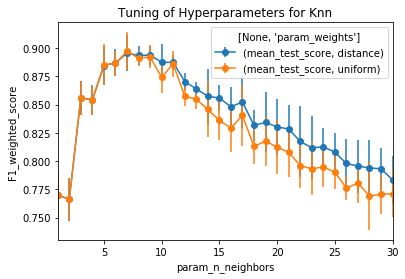

In [98]:
# Let's visualize the evolution of the weighted avergae for different combinasions of the hyperparameters
def plot_results( grid ,par_1,par_2, title, y_lab):
   """Select two hyperparameters from which we plot the fluctuations"""
   index = 'param_' + par_1
   columns = 'param_' + par_2

   # prepare the results into a pandas.DataFrame
   df = pd.DataFrame(grid.cv_results_)

   # Remove the other by selecting their best values (from gscv.best_params_)
   other = [c for c in df.columns if c[:6] == 'param_']
   other.remove(index)
   other.remove(columns)
   # Create pivot tables for easy plotting
   table_mean = df.pivot_table(index=index, columns=columns,
                               values=['mean_test_score'])
   table_std = df.pivot_table(index=index, columns=columns,
                              values=['std_test_score'])

   # plot the pivot tables
   plt.figure()
   ax = plt.gca()
   for col_mean, col_std in zip(table_mean.columns, table_std.columns):
       table_mean[col_mean].plot(ax=ax, yerr=table_std[col_std], marker='o',
                                 label=col_mean)
   plt.title(title)
   plt.ylabel(y_lab)
   plt.legend(title=table_mean.columns.names)
   plt.show()

plot_results(grid_knn ,par_1 = "n_neighbors",par_2 = "weights", title = "Tuning of Hyperparameters for Knn", y_lab= "F1_weighted_score")

In [90]:
# Let's apply the model with our tuned hyperparamters
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=7)
y_pred_knn = neigh.fit(x_train, y_train).predict(x_test)

In [91]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

         acc       0.88      0.88      0.88        77
        good       0.78      0.50      0.61        14
       unacc       0.96      0.98      0.97       242
       vgood       0.83      0.77      0.80        13

   micro avg       0.93      0.93      0.93       346
   macro avg       0.86      0.78      0.82       346
weighted avg       0.93      0.93      0.93       346



Let's move to decision tree

In [92]:
# onehotencoding
onehotencoder = OneHotEncoder()
df_y = df.iloc[:,6].values
df_x = df.iloc[:,0:6].values
df_x = onehotencoder.fit_transform(df_x).toarray()
x_train, x_test, y_train, y_test = train_test_split(df_x,df_y,test_size = 0.2, random_state = 1, stratify = df_y)

In [93]:
# Gridsearch to determine tune the hyperparameters: max_depth and min_samples_leaf
from sklearn.metrics import f1_score
depth={"max_depth":[1,5,10,15,20,25,30],
      "min_samples_leaf" : [10,20,30]}      

DTC=DecisionTreeClassifier()

grid_dt=GridSearchCV(DTC,param_grid=depth , cv=4, scoring= 'f1_weighted')
grid_dt.fit(x_train,y_train)
dt_result =pd.DataFrame(grid_dt.cv_results_)
grid_dt.best_params_

{'max_depth': 10, 'min_samples_leaf': 10}

In [94]:
#Let's apply the model with the best hyperparameters
from sklearn.tree import DecisionTreeClassifier
final_dt = DecisionTreeClassifier(**grid_dt.best_params_)
y_pred_dt = final_dt.fit(x_train, y_train).predict(x_test)

In [95]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

         acc       0.90      0.94      0.92        77
        good       0.82      0.64      0.72        14
       unacc       1.00      0.98      0.99       242
       vgood       0.81      1.00      0.90        13

   micro avg       0.96      0.96      0.96       346
   macro avg       0.88      0.89      0.88       346
weighted avg       0.96      0.96      0.96       346



Finally, let's use SVM

In [99]:
# onehotencoding for the last time
onehotencoder = OneHotEncoder()
df_y = df.iloc[:,6].values
df_x = df.iloc[:,0:6].values
df_x = onehotencoder.fit_transform(df_x).toarray()
x_train, x_test, y_train, y_test = train_test_split(df_x,df_y,test_size = 0.2, random_state = 1, stratify = df_y)

In [101]:
# grid search to determine the best combination of hyperparameters: C and tol
# As logistic regression seems to be performing weel, it looks like the data 
# is linearly separable, so let's use the linear kernel
from sklearn import svm
c_values = [0.01,0.1,1,10,100,1000]
tol_values = [0.0001,0.001,0.01,0.1]

param_grid = dict(C = c_values, tol = tol_values)

SVC_mod = svm.SVC(kernel = 'linear')
grid_svc = GridSearchCV(SVC_mod, param_grid, cv = 4, scoring = 'f1_weighted')
grid_svc.fit(x_train,y_train)
grid_svc.best_params_

{'C': 10, 'tol': 0.01}

In [102]:
# Finally, let's apply svm with these hyperparameters
final_svc = svm.SVC(**grid_svc.best_params_)
y_pred_svc = final_svc.fit(x_train, y_train).predict(x_test)

In [103]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

         acc       0.97      0.97      0.97        77
        good       1.00      0.93      0.96        14
       unacc       1.00      0.99      0.99       242
       vgood       0.87      1.00      0.93        13

   micro avg       0.99      0.99      0.99       346
   macro avg       0.96      0.97      0.96       346
weighted avg       0.99      0.99      0.99       346



Out of our 5 models, and based on the weighted average f1-score, SVM is the best model.
Regarding per-class performance, all the models share the fact that they perform better for the class 'unacc', which is
expected as that class represents 70% of the entire records of the dataset.

In [85]:
df['class'].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64